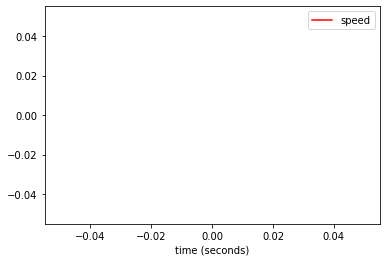

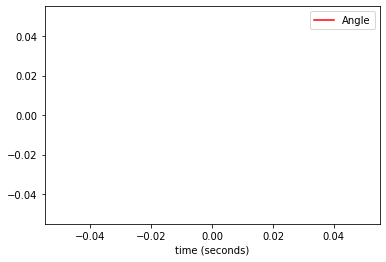

In [1]:
#
# use with godot/arm3_no_physics
#
import sys
sys.path.append("../../")

from lib.data.dataplot import *
from lib.dds.dds import *
from lib.utils.time import *
from lib.system.controllers import *
from lib.system.manipulator import *

class ManipulatorRobot:

    def __init__(self):
        self.arm = ThreeJointsPlanarArm(0.2, 0.2, 0.02,
                                        0.5, 0.5, 0.5,
                                        0.8)

        # joint 1
        self.speed_control_1 = PID_Controller(40, 10, 0,
                                              20)  # 20Nm max torque, antiwindup

        # joint 2
        self.speed_control_2 = PID_Controller(20, 5, 0,
                                              20)  # 20Nm max torque, antiwindup

        # joint 3
        self.speed_control_3 = PID_Controller(1, 0.4, 0,
                                              20)  # 20Nm max torque, antiwindup

        self.pos_control_1 = PID_Controller(2, 0, 0, 2)  # 2 rad/s max speed
        self.pos_control_2 = PID_Controller(2, 0, 0, 2)  # 2 rad/s max speed
        self.pos_control_3 = PID_Controller(2, 0, 0, 2)  # 2 rad/s max speed

        #self.theta1 = math.radians(20)
        #self.theta2 = math.radians(-40)
        #self.theta3 = math.radians(40)
        (self.theta1, self.theta2, self.theta3) = self.arm.inverse_kinematics(0.2, 0.1, math.radians(-90))

    def evaluate(self, delta_t):

        wref_1 = self.pos_control_1.evaluate(delta_t, self.theta1 - self.arm.element_1.theta)
        wref_2 = self.pos_control_2.evaluate(delta_t, self.theta2 - self.arm.element_2.theta)
        wref_3 = self.pos_control_3.evaluate(delta_t, self.theta3 - self.arm.element_3.theta)
        
        torque1 = self.speed_control_1.evaluate(delta_t, wref_1 - self.arm.element_1.w)
        torque2 = self.speed_control_2.evaluate(delta_t, wref_2 - self.arm.element_2.w)
        torque3 = self.speed_control_3.evaluate(delta_t, wref_3 - self.arm.element_3.w)

        self.arm.evaluate(delta_t, torque1, torque2, torque3)

    def get_joint_angles(self):
        return self.arm.get_joint_angles()


dps = DataPlotter()
dps.set_x("time (seconds)")
dps.add_y("speed", "speed")

dpa = DataPlotter()
dpa.set_x("time (seconds)")
dpa.add_y("angle", "Angle")

dds = DDS()
dds.start()

dds.subscribe(['tick'])

robot = ManipulatorRobot()

t = Time()
t.start()
while t.get() < 3:
    
    dds.wait('tick')    
    delta_t = t.elapsed()
    
    robot.evaluate(delta_t)
    (t1, t2, t3) = robot.get_joint_angles()

    dds.publish('theta1', t1, DDS.DDS_TYPE_FLOAT)
    dds.publish('theta2', t2, DDS.DDS_TYPE_FLOAT)
    dds.publish('theta3', t3, DDS.DDS_TYPE_FLOAT)

dps.plot()
dpa.plot()

dds.stop()

